In [1]:
import numpy as np

import torch
import torchvision # здесь находятся различные популярные датасеты

if torch.cuda.is_available():
    print("CUDA available")
    torch.cuda.manual_seed(0)
else:
    print("No CUDA for you :(")
    
print(torch.__version__)
%config InlineBackend.figure_format ='retina' # чтобы графики были красивее


CUDA available
1.1.0


# Зачем нужен pytorch?

1) Замена ```numpy```  свозможностью работы на GPU 

2) Низкоуровневая библиотека для ```DEEP LEARNING```

# Базовые операции

Основным элементом ```pytorch``` являются __тензоры__ - мы будем воспринимать их как н-мерные массивы.<br> 
Пример:

In [2]:
torch.zeros(5,4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [3]:
torch.rand(5,4)

tensor([[0.2429, 0.0491, 0.9640, 0.1701],
        [0.4540, 0.0652, 0.9835, 0.2029],
        [0.7102, 0.1049, 0.1260, 0.0643],
        [0.1535, 0.2632, 0.9713, 0.3331],
        [0.7554, 0.1940, 0.0049, 0.0763]])

Создавать тензоры можно и вручную из списков и из массивов:

In [4]:
print(torch.tensor([1,2,3]))
print(torch.tensor(np.array([1,2,3])))

tensor([1, 2, 3])
tensor([1, 2, 3])


Также можно тензоры обратно переводить в массивы ```numpy``` за константное время:

In [5]:
x = torch.rand(10,10)
%timeit x.numpy
x = torch.rand(100,100)
%timeit x.numpy
x = torch.rand(1000,1000)
%timeit x.numpy

47.7 ns ± 1.86 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
47.7 ns ± 3.04 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
44.8 ns ± 1.78 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Точно так же, как и в ```numpy```, можно производить арифметические операции над тензорами:

In [6]:
x = torch.ones(5,3)
y = torch.rand(5, 3)

In [7]:
print(x)
print(y)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.2321, 0.3217, 0.9892],
        [0.9669, 0.9945, 0.0761],
        [0.9869, 0.1623, 0.4165],
        [0.6952, 0.0989, 0.6357],
        [0.5219, 0.7796, 0.8784]])


In [8]:
print(x+y)
print(torch.add(x,y))

tensor([[1.2321, 1.3217, 1.9892],
        [1.9669, 1.9945, 1.0761],
        [1.9869, 1.1623, 1.4165],
        [1.6952, 1.0989, 1.6357],
        [1.5219, 1.7796, 1.8784]])
tensor([[1.2321, 1.3217, 1.9892],
        [1.9669, 1.9945, 1.0761],
        [1.9869, 1.1623, 1.4165],
        [1.6952, 1.0989, 1.6357],
        [1.5219, 1.7796, 1.8784]])


In [9]:
print(x*y)
print(torch.mul(x,y))

tensor([[0.2321, 0.3217, 0.9892],
        [0.9669, 0.9945, 0.0761],
        [0.9869, 0.1623, 0.4165],
        [0.6952, 0.0989, 0.6357],
        [0.5219, 0.7796, 0.8784]])
tensor([[0.2321, 0.3217, 0.9892],
        [0.9669, 0.9945, 0.0761],
        [0.9869, 0.1623, 0.4165],
        [0.6952, 0.0989, 0.6357],
        [0.5219, 0.7796, 0.8784]])


Операции, заканчивающиеся на нижнее подчеркивание, __не чистые__, то есть они изменяют элемент, к которому были применены. <br> Пример:

In [10]:
print(y)
y.add_(x)
print(y)

tensor([[0.2321, 0.3217, 0.9892],
        [0.9669, 0.9945, 0.0761],
        [0.9869, 0.1623, 0.4165],
        [0.6952, 0.0989, 0.6357],
        [0.5219, 0.7796, 0.8784]])
tensor([[1.2321, 1.3217, 1.9892],
        [1.9669, 1.9945, 1.0761],
        [1.9869, 1.1623, 1.4165],
        [1.6952, 1.0989, 1.6357],
        [1.5219, 1.7796, 1.8784]])


В ```pytorch``` поддерживаются вычисления на видеокарте:

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")          
    y = torch.ones_like(x, device=device)  
    x = x.to(device)                       
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))     
else:
    print("FeelsBadMan")

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]], device='cuda:0')
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]], dtype=torch.float64)


# AUTOGRAD

Пакет ```autograd``` - одна из самых важных вещей в ```pytorch```. В нем находятся функции для автоматического взятия производных от тензоров. 

У ```torch.tensor``` есть аттрибут ```.requires_grad``` , и если его поставить ```True``` , то все операции над этим тензором начнут записываться, чтобы можно было взять производную.

In [12]:
x = torch.ones(2,2, requires_grad = True)

In [13]:
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

Чтобы остановить отслеживание операций, к тензору надо применить метод ```.detach()```

Еще один важное понятие  для ```autograd``` - это ```.grad_fn```<br>
Это аттрибут тензора, который показывает, с помощью какой функции был создан этот тензор.<br> Если тензор был создан вручную, то ```.grad_fn = None```

In [14]:
print(x.grad_fn)

None


In [15]:
y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [16]:
print(y.grad_fn)

Чтобы посчитать производную тензора, к нему применяется метод ```.baсkward()```.

Если тензор состоял из единственного числа, то в ```.backward``` никаких аргументов передавать не нужно. <br>
[Подробнее об аргументах ```.backward``` - второй ответ](https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments)

Создадим тензор с ```.requires_grad = True``` для отслеживания вычислений над ним, и совершим несколько операций:

In [17]:
x = torch.ones(2,2,requires_grad = True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [18]:
y = x + 2

In [19]:
z = 3 * y**2
z.requires_grad_(True)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)

In [20]:
out = z.mean()
out

tensor(27., grad_fn=<MeanBackward0>)

In [21]:
out.backward(torch.tensor([1.]))

In [22]:
x.grad

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

Объяснение произошедшему:

$$
\begin{align}
\textbf{out} = \frac14 \sum_i{z_i} = \frac14 \sum_i{3~(x_i+2)^2} \newline
\newline
\frac{\partial ~\textbf{out}}{\partial ~x_i} = \frac{\partial ~out}{\partial ~z} \frac{\partial ~z}{\partial ~y} \frac{\partial ~y}{\partial ~x_i} 
\newline
\newline
\frac{\partial ~\textbf{out}}{\partial ~x_i} =  \frac32~(x_i+2) = \frac92 = 4.5
\end{align}
$$

<div class="alert alert-warning">

<b>Задание</b>

```x = torch.eye(2, requires_grad = True)
y = x/12
z = (y + 5)**2
out = z.sum()```
<br>
<br>
Что вернет ```x.grad``` после вызова ```out.backward()```?
</div>

# Нейронные сети

Построим модель нейронной сети, в которой мы сами реализуем разбиение данных на мини-батчи, итерации по ним и прямое распространение(```forward propagation```). <br>
Обратное распространение (```backpropagation```) сделаем при помощи ```.backward```

In [23]:
import time
from sklearn.datasets import make_moons # генератор данных 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [24]:
xm, ym = make_moons(n_samples = 10000, noise=0.1)
ym = ym.reshape(-1,1)
xm_train, xm_test, ym_train, ym_test = [torch.tensor(i) for i in train_test_split(xm,ym, test_size = 0.2)]

Генератор минибатчей:

In [25]:
def generate_minibatches(inputs, targets, batchsize = 16, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_id in range(0, inputs.shape[0], batchsize):
        end_id = min(start_id + batchsize, inputs.shape[0])
        if shuffle:
            batch_indices = indices[start_id:end_id]
        else:
            batch_indices = slice(start_id, end_id)
        yield inputs[batch_indices], targets[batch_indices]

В ```pytorch``` модель состоит из слоев, например ```nn.Linear(...)```<br>
```nn.Linear(...)``` - набор параметров (матрица весов и вектор смещения)

In [26]:
list(nn.Linear(2,20).parameters())

[Parameter containing:
 tensor([[-0.3384, -0.1434],
         [ 0.4417, -0.4705],
         [ 0.6971, -0.0622],
         [ 0.0152, -0.6456],
         [-0.1543,  0.0858],
         [-0.2988, -0.6053],
         [ 0.0841,  0.6390],
         [ 0.0080,  0.5917],
         [-0.0421, -0.2467],
         [ 0.5977, -0.6971],
         [ 0.0961, -0.5352],
         [-0.6605,  0.1389],
         [ 0.2459, -0.2972],
         [ 0.6533,  0.4164],
         [ 0.0262,  0.5639],
         [-0.5616,  0.2540],
         [-0.5884, -0.6602],
         [ 0.6751,  0.3108],
         [ 0.5011,  0.2392],
         [ 0.3176, -0.5926]], requires_grad=True), Parameter containing:
 tensor([-0.6308, -0.0173, -0.2542, -0.6184, -0.0598, -0.2720,  0.2251, -0.5123,
         -0.5430,  0.2108,  0.2676,  0.2782, -0.5270,  0.1903,  0.0740,  0.1075,
          0.2766, -0.6817, -0.6117,  0.3875], requires_grad=True)]

Чтобы задать модель нейронной сети, надо определить методы ```__init__```, в котором определяется структура нейронной сети, и ```forward```, где описывается прямое распространение. <br>
А также модель должна наследовать класс ```nn.Module```

## Создание

In [27]:
class Net(nn.Module):

    def __init__(self, seed = 0):
        super().__init__()
            
        self.l1 = nn.Linear(2, 20)
        self.l2 = nn.Linear(20, 1)
        
        
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        
        return x

net = Net()
print(net)

Net(
  (l1): Linear(in_features=2, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=1, bias=True)
)


В ```pytorch``` представлены несколько видов функций потерь, например: <br>
```nn.MSELoss()``` - Mean Squared Error <br>
```nn.L1Loss()``` - MAE <br>
```nn.CrossEntropyLoss()``` - перекрестная энтропия, в которую входит softmax<br>
То есть, если мы хотим использовать ```nn.CrossEntropyLoss()``` в качестве функции потерь в модели нейронной сети, на последнем слое __не надо применять softmax__. Также особенностью реализации ```nn.CrossEntropyLoss()``` в ```pytorch``` является то, что эта функция потерь принимает на вход __не one-hot-encoded вектора__, а обычные номера классов.
    
[Полный список функций потерь](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)

## Обучение

В этом примере мы взяли на себя итерирование по эпохам, минибатчам, подсчет функционала качества, обновление значений весов и смещений и обнуление градиентов тензоров после обновления.

### Зачем обнулять градиенты?
Каждый раз, когда вызывается метод ```.backward``` градиенты тензоров не обновляются (то есть их __не замещают новые значения__), а __накапливаются__. Поэтому, чтобы градиенты не смешивались, необходимо на каждом шаге их обнулять.

In [28]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed) # это нужно, так как генератор минибатчей использует np.random.shuffle


net1 = Net()

criterion = nn.MSELoss()

lr = 0.1

for epoch in range(100):
    
    running_loss = 0.0
    
    for batch in generate_minibatches(xm_train,ym_train,64,shuffle = True):
        
        data, labels = batch
        
        # Прямое распространение
        output = net1(data.float())
        
        # Подсчет ошибки на батче
        loss = criterion(output, labels.float())
        
        # Обратное распространение
        loss.backward()
    
        #Обновление весов и обнуление градиентов
        with torch.no_grad(): # torch.no_grad() отключает отслеживание вычислений над тензорами в блоке
            for parameter in net1.parameters():
                parameter.data -= lr * parameter.grad
                parameter.grad = torch.zeros_like(parameter)

        running_loss += loss.item()
            
            
    if epoch%10==0:
        print(f"Loss on epoch {epoch} - {running_loss}") 
        

Loss on epoch 0 - 20.018548607826233
Loss on epoch 10 - 9.338071977719665
Loss on epoch 20 - 7.126234192401171
Loss on epoch 30 - 4.094889936968684
Loss on epoch 40 - 2.287942968774587
Loss on epoch 50 - 1.5102367596700788
Loss on epoch 60 - 1.1316262218169868
Loss on epoch 70 - 0.9088677535764873
Loss on epoch 80 - 0.767420397256501
Loss on epoch 90 - 0.6678517437539995


Того же самого результата можно добиться, используя встроенные в ```pytorch``` оптимизаторы и функции для обновления и обнуления градиентов.

Виды возможных оптимизаторов:<br>
```optim.SGD``` - стохастический градиентный градиентный спуск (на самом деле, ему можно подавать батч любого размера, так что SGD - градиентный спуск по минибатчам)<br>
```optim.Adam```  [ссылка на курсеру](https://www.coursera.org/learn/deep-neural-network/lecture/w9VCZ/adam-optimization-algorithm)<br>
```optim.RMSprop```  [ссылка на курсеру](https://www.coursera.org/learn/deep-neural-network/lecture/BhJlm/rmsprop) <br>
<br>
[Полный список оптимизаторов](https://pytorch.org/docs/stable/optim.html])

Чтобы инициализировать оптимизатор, в него надо передать параметры обучаемой модели ```net.parameters()``` и начальную скорость обучения (learning rate)

In [29]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
    
net2 = Net()

# В нашем случае будем использовать обычный градиентный спуск по минибатчам, как и в прошлый раз
optimizer = optim.SGD(net2.parameters(), lr = 0.1)

criterion = nn.MSELoss()

for epoch in range(100):
    running_loss = 0.0
    for batch in generate_minibatches(xm_train,ym_train,64,shuffle = True):
        
        data, labels = batch
        
        # Прямое распространение
        output = net2(data.float())
        
        # Подсчет ошибки на батче
        loss = criterion(output, labels.float())
        
        # Обратное распространение
        loss.backward()
        
        #Обновление весов
        optimizer.step()
        
        #Обнуление градиентов
        optimizer.zero_grad() 
        
        running_loss += loss.item()
            
    if epoch%10==0:
        print(f"Loss on epoch {epoch} - {running_loss}") 

Loss on epoch 0 - 20.01854820549488
Loss on epoch 10 - 9.338072014972568
Loss on epoch 20 - 7.126234911382198
Loss on epoch 30 - 4.09489004034549
Loss on epoch 40 - 2.2879429147578776
Loss on epoch 50 - 1.5102364635095
Loss on epoch 60 - 1.1316260362509638
Loss on epoch 70 - 0.908867614576593
Loss on epoch 80 - 0.7674200985347852
Loss on epoch 90 - 0.6678514525992796


Посмотрим, что получилось:

In [30]:
def plot_labels(data,target):
    df = pd.DataFrame(dict(x=data[:,0], y=data[:,1], label=target))
    colors = {0:'red', 1:'blue'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()

In [31]:
import matplotlib.pyplot as plt
plot_labels(xm_test.numpy(),np.round(net2(xm_test.float()).detach()).reshape(-1,))

<Figure size 640x480 with 1 Axes>

# MNIST

Обучим нейронную сеть на датасете Fashion MNIST, содержащем 10 видов различной одежды:

In [32]:
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils.np_utils import to_categorical  
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train/255
x_test = x_test/255

ycat_train = to_categorical(y_train, num_classes=10)
ycat_test = to_categorical(y_test, num_classes=10)

Using TensorFlow backend.


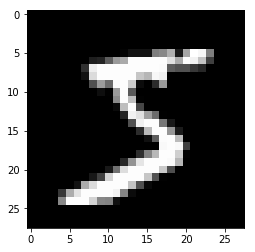

In [33]:
plt.imshow(x_train[0],cmap = 'gray')

In [34]:
ycat_train = torch.tensor(ycat_train)
ycat_test = torch.tensor(ycat_test)

x_train = torch.tensor(x_train).view(-1,28*28).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).view(-1,28*28).float()
y_test = torch.tensor(y_test).float()


In [35]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

torch.Size([60000, 784]) torch.Size([60000]) torch.Size([10000, 784]) torch.Size([10000])


Построим модель с ```nn.CrossEntropyLoss()```. На последнем слое не будем применять ```torch.softmax```, так как в ```nn.CrossEntropyLoss()``` эта функция уже применяется. <br>
Но чтобы получить нормальные предсказания в виде вектора вероятностей быть той или иной цифрой и проверить точность предсказаний, применить ```torch.softmax``` все же придется.

In [36]:
class MnistSoftmaxNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = MnistSoftmaxNet()
print(net)

MnistSoftmaxNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [57]:
#!pip install tqdm

from tqdm import trange

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
    
net = MnistSoftmaxNet()


optimizer = optim.Adam(net.parameters())

criterion = nn.CrossEntropyLoss()

for epoch in trange(5):
    running_loss = 0.0
    for batch in generate_minibatches(x_train, y_train, 64, shuffle = True):
        
        data, labels = batch
        
        # Прямое распространение
        output = net(data)
        
        # Подсчет ошибки на батче
        loss = criterion(output, labels.long()) 
        
        # Обратное распространение
        loss.backward()
        
        #Обновление весов
        optimizer.step()
        
        #Обнуление градиентов
        optimizer.zero_grad() 
        
        #running_loss += loss.item()
            
    if epoch%1==0:
        print(f"Loss on epoch {epoch} - {running_loss}") 



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

Loss on epoch 0 - 0.0




 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

Loss on epoch 1 - 0.0




 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

Loss on epoch 2 - 0.0




 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

Loss on epoch 3 - 0.0




100%|██████████| 5/5 [00:12<00:00,  2.57s/it]

Loss on epoch 4 - 0.0


Получили довольно высокую точность на тестовой выборке:

In [56]:
accuracy_score(torch.argmax(torch.softmax(net(x_test.float(),-1),dim = -1), y_test)

0.975

На самом деле, создавать модели можно и более простым способом. Но тогда теряется гибкость настройки модели и мы лишаемся возможности создавать свои слои:

In [39]:
layers = []
layers.append(nn.Linear(768, 128))
layers.append(nn.ReLU())
layers.append(nn.Linear(128, 64))
layers.append(nn.ReLU())
layers.append(nn.Linear(64, 10))

net = nn.Sequential(*layers)

In [40]:
net

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [66]:
#!pip install tqdm

from tqdm import trange

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
    
net = MnistSoftmaxNet().cuda()


optimizer = optim.Adam(net.parameters())

criterion = nn.CrossEntropyLoss()

for epoch in trange(5):
    running_loss = 0.0
    for batch in generate_minibatches(x_train.cuda(), y_train.cuda(), 64, shuffle = True):
        
        data, labels = batch
        
        # Прямое распространение
        output = net(data)
        
        # Подсчет ошибки на батче
        loss = criterion(output, labels.long()) 
        
        # Обратное распространение
        loss.backward()
        
        #Обновление весов
        optimizer.step()
        
        #Обнуление градиентов
        optimizer.zero_grad() 
        
        running_loss += loss #вызов .item() переводит полученное число на cpu, что замедляет работу
    if epoch%1==0:
        print(f"Loss on epoch {epoch} - {running_loss}") 





  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:01<00:07,  1.87s/it]

Loss on epoch 0 - 325.4367370605469






 40%|████      | 2/5 [00:03<00:05,  1.87s/it]

Loss on epoch 1 - 131.55807495117188






 60%|██████    | 3/5 [00:05<00:03,  1.89s/it]

Loss on epoch 2 - 89.6699447631836






 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

Loss on epoch 3 - 66.72305297851562






100%|██████████| 5/5 [00:10<00:00,  2.22s/it]

Loss on epoch 4 - 51.70305633544922


In [67]:
accuracy_score(torch.argmax(torch.softmax(net(x_test.float().cuda()),-1),dim = -1).cpu(), y_test)

0.975

# Заключение

Мы рассмотрели базовые понятия ```pytorch``` и научились строить модели полносвязных нейронных сетей используя встроенные функции.